# Symulator tomografu komputerowego

**Data:** xx.03.2022

**Autorzy:**

Jakub Kwiatkowski 145356\
Paweł Strzelczyk 145217

## Abstrakt

`TODO`

#### Wykorzystane technologie

- [python](https://python.org) (v3.10)
- [jupyter notebooks](https://jupyter.org)


In [1]:
from ipywidgets import interact
import cv2 as cv
import ipywidgets
import numpy as np
import pydicom as dcm
import matplotlib.pylab as plt
import math
from skimage import io, draw
from ct_utils import bresenham

In [2]:
# TODO: Transform image into sinogram (Radon transform)

In [3]:
# TODO: Draw sinograph (sinogram visualization, every column in sinograph corresponds to row in sinogram)

sinogram


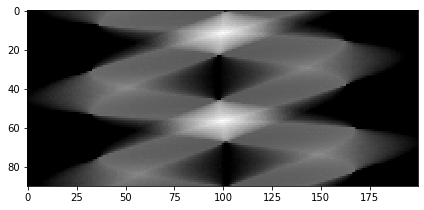

In [4]:
def normalize(image):
        max_val = np.amax(image)
        image = image / max_val * 255
        
        return image / 255.0

sinogram = cv.imread('data/sin_sample.png', cv.IMREAD_GRAYSCALE)
print('sinogram')
io.imshow(sinogram)

# TODO: Inverse Radon transform (function should take number of iterations as argument)
# step - Δα (a)
# phi - angular span of detectors (c)
# img_size - output image size, radon transform changes dimensions
# detectors - number of detectors for one set (b)
def inverse_radon(sinogram, step=4, detectors=200, phi=180, img_size=0):
    
    # output image as np.array
    image = np.zeros((img_size, img_size))
    
    # transform to radians
    step = np.deg2rad(step)
    phi = np.deg2rad(phi)

    # radius //można potem ramke dołożyć
    r = img_size / 2

    # number of iterations 
    iterations = math.ceil(2 * np.pi / step)

    alpha = 0
    for iteration in range(iterations):
        
        # E = [x_e, y_e]
        x_e = r * np.cos(alpha)
        y_e = r * np.sin(alpha)
        
        # emitter position
        x_e, y_e = x_e + r, y_e + r

        for i in range(detectors):
            
            # D = [x_d, y_d]
            x_d = r * np.cos(alpha + np.pi - phi / 2 + i * (phi / (detectors - 1)))
            y_d = r * np.sin(alpha + np.pi - phi / 2 + i * (phi / (detectors - 1)))
            
            # detector position
            x_d, y_d = x_d + r, y_d + r
            
            # ------------------
            # line_nd draw is faster imo
            # line = draw.line_nd([x_e, y_e], [x_d, y_d])
            # image[line[1], line[0]] += sinogram[iteration, i]
            # ------------------
            
            # bresenham line
            line = bresenham([x_e.astype('int'), y_e.astype('int')], [x_d.astype('int'), y_d.astype('int')])
            
            xs = []
            ys = []
            
            # points on the line coordinates
            for x, y in line:
                xs = np.append(xs, x)
                ys = np.append(ys, y)
            
            xs = xs.astype('int')
            ys = ys.astype('int')

            # transform
            image[ys, xs] += sinogram[iteration, i]

        # next step - change angle
        alpha += step

    image = normalize(image)

    return image



reconstructed


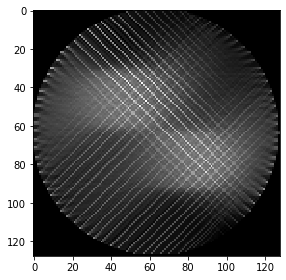

In [5]:
img = inverse_radon(sinogram, img_size=128)

print('reconstructed')
io.imshow(img);